## **Boids 🦜🐟**

### **Importações**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider

np.random.seed(404)

### **Configurações Iniciais**

In [7]:
CONFIG = {
    "N_PRESAS": 100,
    "N_PREDADORES": 2,
    "WIDTH": 100,
    "HEIGHT": 100,
}

parametros = {
    "width": CONFIG["WIDTH"],
    "height": CONFIG["HEIGHT"],
    "dt": 0.5,
    
    "max_velocidade_presa": 2.3,
    "max_velocidade_pred": 2,
    
    "peso_coesao": 1.0,        
    "peso_alinhamento": 1.0,
    "peso_separacao": 1.5,
    
    "peso_fuga": 2.0,        
    "peso_perseguicao": 0.7, 
    "peso_separacao_pred": 0.2,
    
    "raio_percepcao_presa": 10.0,
    "raio_percepcao_predador": 15.0,    
    "raio_barreira": 10.0,    
    "forca_barreira": 0.8,   
}

### **Função para Inicializar as Posições e Velocidades**

In [8]:
def init_simulation(config, params):
    """Inicializa as posições e velocidades dos agentes."""
    w, h = config["WIDTH"], config["HEIGHT"]
    
    presas_pos = np.random.rand(config["N_PRESAS"], 2) * np.array([w, h])
    presas_vel = (np.random.rand(config["N_PRESAS"], 2) - 0.5) * params["max_velocidade_presa"]

    preds_pos = np.random.rand(config["N_PREDADORES"], 2) * np.array([w, h])
    preds_vel = (np.random.rand(config["N_PREDADORES"], 2) - 0.5) * params["max_velocidade_pred"]
    
    return presas_pos, presas_vel, preds_pos, preds_vel

presas_pos, presas_vel, preds_pos, preds_vel = init_simulation(CONFIG, parametros)

### **Função dos Cálculos**

**Regras para os boids**

- Separação:

$$
\vec{V}_{j} = \frac{S(\vec{r}_{j}-\vec{r}_{k})}{||\vec{r}||^{2}}
$$

- Alinhamento (modificado para peixes): 

$$
\vec{V}_{j}^{n+1} = (1-M)v_{j} + \frac{M}{k}\sum_{i=1}^{k}\vec{V}_{i}
$$

- Coesão: 
 
$$\vec{r}_{CM} = \frac{1}{N}\sum_{i=1}^{N}\vec{r}_{i}$$

$$\vec{V}_{j} = C(\vec{r}_{j}-\vec{r}_{CM})$$

Onde: 
- $S$ é o coeficiente de separação.
- $k$ é o número de vizinhos dentro do raio de interação.
- $C$ é o coeficiente de alinhamento.
- $M$ é o termo da média (peso da influência vizinha).

In [9]:
def update_boids(pos_presas, vel_presas, pos_predadores, vel_predadores, params):
    n_presas = len(pos_presas)
    n_predadores = len(pos_predadores)
    
    L_x, L_y = params["width"], params["height"]
    raio_presa = params["raio_percepcao_presa"]
    dt = params["dt"]

    # --- Distâncias (Presa-Presa) ---
    diferenca_presas = pos_presas[:, None] - pos_presas
    distancias_presas = np.linalg.norm(diferenca_presas, axis=2)
    np.fill_diagonal(distancias_presas, np.inf) # Evita divisão por zero consigo mesmo
    
    vizinhos_presas = (distancias_presas < raio_presa)
    num_vizinhos = np.sum(vizinhos_presas, axis=1)

    # Inicialização dos vetores de velocidade
    v_coesao = np.zeros((n_presas, 2))
    v_alinhamento = np.zeros((n_presas, 2))
    v_separacao = np.zeros((n_presas, 2))
    v_fuga = np.zeros((n_presas, 2))
    v_barreira = np.zeros((n_presas, 2))
    v_barreira_pred = np.zeros((n_predadores, 2))

    # --- Processo de Movimentação ---
    diferenca_predadores = pos_presas[:, None] - pos_predadores
    distancia_predadores = np.linalg.norm(diferenca_predadores, axis=2)
    raio_pred = params["raio_percepcao_predador"]
    mask_perigo = distancia_predadores < raio_pred

    if np.any(mask_perigo):
        predador_mais_prox_idx = np.argmin(distancia_predadores, axis=1)
        for i in range(n_presas):
            if np.any(mask_perigo[i]):
                idx_p = predador_mais_prox_idx[i]
                if distancia_predadores[i, idx_p] < raio_pred:
                    v_fuga[i] = diferenca_predadores[i, idx_p] / (distancia_predadores[i, idx_p] + 1e-5)**(3/2)

    # --- Aplicão das Regras de Boids ---
    for i in range(n_presas):
        mask_vizinhos = vizinhos_presas[i]
        if np.any(mask_vizinhos):
            # Coesão:
            avg_posicao = np.mean(pos_presas[mask_vizinhos], axis=0)
            v_coesao[i] = (avg_posicao - pos_presas[i])

            # Alinhamento:
            avg_vel = np.mean(vel_presas[mask_vizinhos], axis=0)
            v_alinhamento[i] = (avg_vel - vel_presas[i])

            # Separação: 
            diferenca_vizinhos = pos_presas[i] - pos_presas[mask_vizinhos]
            v_separacao[i] = np.sum(diferenca_vizinhos / (distancias_presas[i, mask_vizinhos][:, None] + 1e-5), axis=0)

    # --- Força das Barreiras ---
    E = params["raio_barreira"]
    A = params["forca_barreira"]
    
    # Presas
    v_barreira[:, 0] = A * np.exp(-(pos_presas[:, 0] / E)**2) - A * np.exp(-((pos_presas[:, 0] - L_x) / E)**2)
    v_barreira[:, 1] = A * np.exp(-(pos_presas[:, 1] / E)**2) - A * np.exp(-((pos_presas[:, 1] - L_y) / E)**2)

    # Predadores
    v_barreira_pred[:, 0] = A * np.exp(-(pos_predadores[:, 0] / E)**2) - A * np.exp(-((pos_predadores[:, 0] - L_x) / E)**2)
    v_barreira_pred[:, 1] = A * np.exp(-(pos_predadores[:, 1] / E)**2) - A * np.exp(-((pos_predadores[:, 1] - L_y) / E)**2)

    # --- Mudanças de Velocidade ---
    vel_presas += (v_coesao * params["peso_coesao"] + 
                   v_alinhamento * params["peso_alinhamento"] + 
                   v_separacao * params["peso_separacao"] +
                   v_fuga * params["peso_fuga"] + 
                   v_barreira)

    # Penalidade por multidão [1]
    mask_multidao = num_vizinhos > (0.2 * n_presas)
    vel_presas[mask_multidao] *= 0.9  

    # Limite de velocidade (Presas)
    speed = np.linalg.norm(vel_presas, axis=1)
    mask_limit = speed > params["max_velocidade_presa"]
    vel_presas[mask_limit] = (vel_presas[mask_limit] / (speed[mask_limit][:, None] + 1e-8)) * params["max_velocidade_presa"]
    
    # Atualização da posição 
    pos_presas += vel_presas * dt

    # Evita que os boids saiam da tela (vai que)
    pos_presas[:, 0] = np.clip(pos_presas[:, 0], 0, L_x)
    pos_presas[:, 1] = np.clip(pos_presas[:, 1], 0, L_y)
    
    # --- Mudanças dos Predadores ---
    if n_presas > 0:
        idx_alvo = np.argmin(distancia_predadores, axis=0)
        for j in range(n_predadores):
            alvo_pos = pos_presas[idx_alvo[j]]
            direcao_cacada = alvo_pos - pos_predadores[j]
            norma = np.linalg.norm(direcao_cacada)
            if norma > 0:
                vel_predadores[j] += (direcao_cacada / norma) * params["peso_perseguicao"]
    
    # Repulsão entre predadores 
    if n_predadores > 1:
        diff_preds = pos_predadores[:, None] - pos_predadores
        dist_preds = np.linalg.norm(diff_preds, axis=2)
        np.fill_diagonal(dist_preds, np.inf)
        
        mask_prox_pred = dist_preds < params["raio_percepcao_predador"]
        v_sep_pred = np.zeros_like(vel_predadores)
        
        for j in range(n_predadores):
            vizinhos = mask_prox_pred[j]
            if np.any(vizinhos):
                afastamento = np.sum(diff_preds[j, vizinhos] / (dist_preds[j, vizinhos][:, None] + 1e-5), axis=0)
                v_sep_pred[j] = afastamento
        vel_predadores += v_sep_pred * params["peso_separacao_pred"]
    
    vel_predadores += v_barreira_pred

    # --- Aplicação do Ruído ---
    ruido_max = 0.2
    angulos_ruido = np.random.uniform(-ruido_max, ruido_max, size=len(vel_presas))
    cos_, sen_ = np.cos(angulos_ruido), np.sin(angulos_ruido)

    vel_x_nova = vel_presas[:, 0] * cos_ - vel_presas[:, 1] * sen_
    vel_y_nova = vel_presas[:, 0] * sen_ + vel_presas[:, 1] * cos_
    vel_presas[:, 0] = vel_x_nova
    vel_presas[:, 1] = vel_y_nova

    # Limite velocidade (Predadores)
    speed_p = np.linalg.norm(vel_predadores, axis=1)
    mask_limit_p = speed_p > params["max_velocidade_pred"]
    vel_predadores[mask_limit_p] = (vel_predadores[mask_limit_p] / (speed_p[mask_limit_p][:, None] + 1e-8)) * params["max_velocidade_pred"]
        
    pos_predadores += vel_predadores * dt

    return pos_presas, vel_presas, pos_predadores, vel_predadores

### **Visualização - Configurações do Matplotlib**


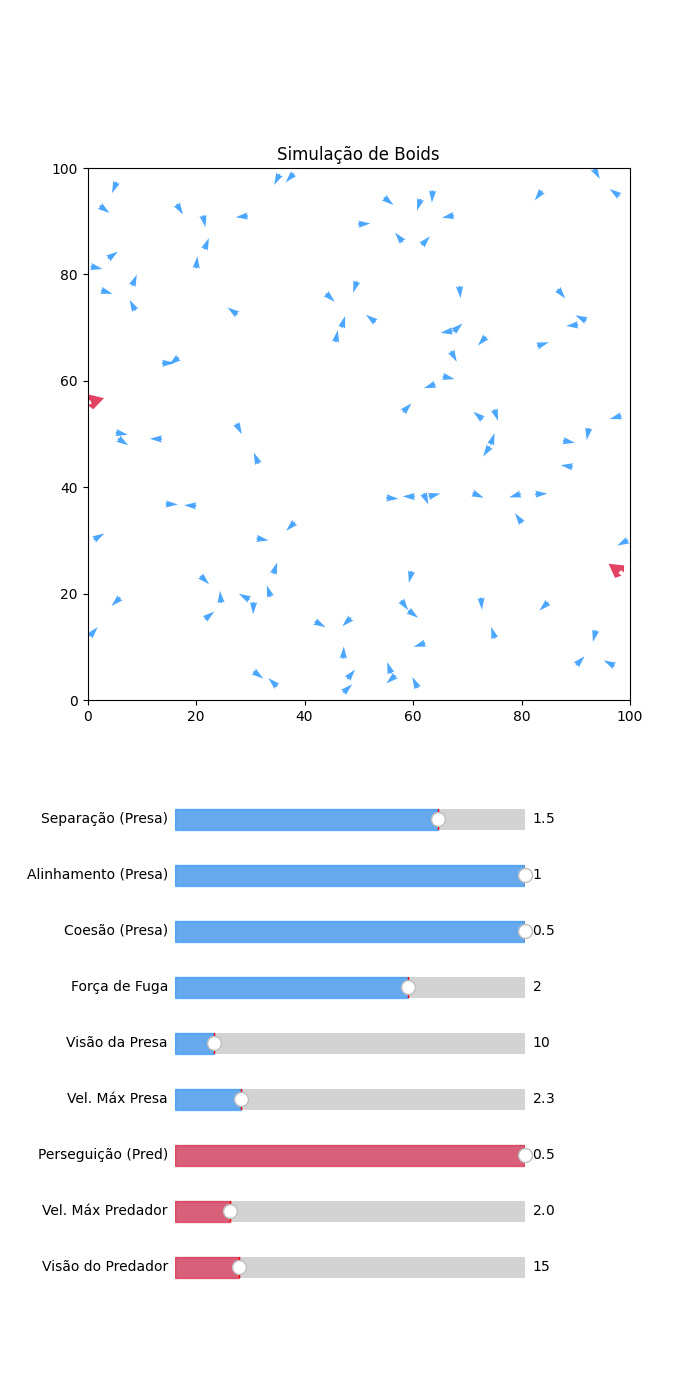

In [10]:
%matplotlib widget

try:
    anim.event_source.stop()
except NameError:
    pass
plt.close('all')

fig, ax = plt.subplots(figsize=(7, 14))
fig.canvas.header_visible = False  
plt.subplots_adjust(bottom=0.5)

ax.set_xlim(0, parametros["width"])
ax.set_ylim(0, parametros["height"])
ax.set_title("Simulação de Boids")

# Texto de tempo
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, 
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# Inicialização dos Setas (Quivers)
init_norm = np.linalg.norm(presas_vel, axis=1)
vel_norm_init = presas_vel / (init_norm[:, None] + 1e-8)
arrows = ax.quiver(presas_pos[:, 0], presas_pos[:, 1], 
                   vel_norm_init[:, 0], vel_norm_init[:, 1], 
                   color="dodgerblue", pivot="mid", scale=45, headwidth=3, alpha=0.8)

# Predadores
init_norm_p = np.linalg.norm(preds_vel, axis=1)
vel_norm_init_p = preds_vel / (init_norm_p[:, None] + 1e-8)
arrow_pred = ax.quiver(preds_pos[:, 0], preds_pos[:, 1], 
                       vel_norm_init_p[:, 0], vel_norm_init_p[:, 1], 
                       color="crimson", pivot="mid", scale=40, headwidth=4, headlength=3.5, label="Predador", alpha=0.8)

# --- Controles Deslizantes ---
controles = [
    ("peso_separacao", "Separação (Presa)", 0.0, 2.0, parametros["peso_separacao"]),
    ("peso_alinhamento", "Alinhamento (Presa)", 0.0, 1.0, parametros["peso_alinhamento"]),
    ("peso_coesao", "Coesão (Presa)", 0.0, 0.5, parametros["peso_coesao"]),
    ("peso_fuga", "Força de Fuga", 0.0, 3.0, parametros["peso_fuga"]),
    ("raio_percepcao_presa", "Visão da Presa", 5.0, 50.0, parametros["raio_percepcao_presa"]),
    ("max_velocidade_presa", "Vel. Máx Presa", 0.5, 10.0, parametros["max_velocidade_presa"]),
    
    ("peso_perseguicao", "Perseguição (Pred)", 0.0, 0.5, parametros["peso_perseguicao"]),
    ("max_velocidade_pred", "Vel. Máx Predador", 0.5, 10.0, parametros["max_velocidade_pred"]),
    ("raio_percepcao_predador", "Visão do Predador", 5.0, 60.0, parametros["raio_percepcao_predador"]),
]

sliders_dict = {}

def update_parametros(val):
    """Atualização do dicionário de parâmetros"""
    for key, slider in sliders_dict.items():
        parametros[key] = slider.val

start_y = 0.40
spacing = 0.04

for i, (key, label, vmin, vmax, valinit) in enumerate(controles):
    y_pos = start_y - (i * spacing)
    ax_slider = plt.axes([0.25, y_pos, 0.5, 0.03])

    color = "crimson" if "pred" in key or "perseguicao" in key else "dodgerblue"
    
    s = Slider(ax_slider, label, vmin, vmax, valinit=valinit, color=color, alpha=0.6)
    s.on_changed(update_parametros)
    sliders_dict[key] = s

# --- Animação ---
tempo_simulacao = 0

def animate(frame):
    global presas_pos, presas_vel, preds_pos, preds_vel, tempo_simulacao

    presas_pos, presas_vel, preds_pos, preds_vel = update_boids(
        presas_pos, presas_vel, preds_pos, preds_vel, parametros
    )
    
    tempo_simulacao += parametros["dt"]
    time_text.set_text(f"Tempo Simulado: {tempo_simulacao:.1f}")

    # Atualiza as Presas
    speed = np.linalg.norm(presas_vel, axis=1)
    vel_visual = presas_vel / (speed[:, None] + 1e-8)
    arrows.set_offsets(presas_pos)
    arrows.set_UVC(vel_visual[:, 0], vel_visual[:, 1])

    # Atualiza os Predadores
    speed_predador = np.linalg.norm(preds_vel, axis=1)
    vel_visual_p = preds_vel / (speed_predador[:, None] + 1e-8)
    arrow_pred.set_offsets(preds_pos)
    arrow_pred.set_UVC(vel_visual_p[:, 0], vel_visual_p[:, 1])

    return arrows, arrow_pred

anim = FuncAnimation(fig, animate, frames=1000, interval=50, blit=True)
plt.show()

### **Referências**

[1] - BOIDS - Física Computacional. Disponível em: <https://fiscomp.if.ufrgs.br/index.php/BOIDS>. Acesso em: 25 nov. 2025.